<a href="https://colab.research.google.com/github/Sprivacy/DP-Utility-in-ML/blob/main/LR_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount on your google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Neccessary Libraries for DP-SGD
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

TensorFlow 1.x selected.


In [ ]:
#importing libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
!pip install tensorflow_privacy

In [ ]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer,DPAdamGaussianOptimizer

In [ ]:
def load_dataset():
    (trainX,trainY), (testX,testY)=cifar10.load_data()
    trainX=trainX.reshape(50000,32*32*3)
    testX=testX.reshape(10000,32*32*3)
    x1=trainX[30000:50000]
    Xtest=np.vstack((x1,testX)) 
    y1=trainY[30000:50000]
    ytest=np.vstack((y1,testY))
    Xtrain=trainX[0:30000]
    ytrain=trainY[0:30000]
    return Xtrain, ytrain, Xtest, ytest



In [ ]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
    # load the pre-shuffled train and test data
X_train,y_train,X_test,y_test=load_dataset()
X_train,X_test=prep_pixels(X_train,X_test)

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
#simple logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0,penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
diff=model.score(X_train, y_train)-model.score(X_test, y_test)
diff

Input Perturbation

In [ ]:
#create training and testing data for Input Perturbation
n=15000
xtrain=X_train[0:n]
ytrain=y_train[0:n]
xtest=X_test[0:n]
ytest=y_test[0:n]

In [ ]:
#non-private accuracy
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0,penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(xtrain, ytrain)
np_in=model.score(xtest, ytest)
np_in

In [ ]:
#Input Perturbation
ep=[0.01, 0.1,1,10,100,1000,10000]
ni=len(ep)
acc_in=np.zeros(ni)
for i in range(ni):
  epi=ep[i]
  delta=.00001
  z=3*np.log(n)
  z1=z**2
  sigma=z1*(8*np.log(2/(delta/2))+4*epi)/(epi**2)
  nsi=np.random.normal(loc=0.0, scale=sigma/n)
  print(nsi)
  X_in=xtrain-nsi
  model_in = LogisticRegression(random_state=0,penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(X_in, ytrain)
  acc_in[i]=model_in.score(xtest, ytest)

Objective Perturbation

In [ ]:
!pip install diffprivlib

In [ ]:
from diffprivlib.models import LogisticRegression

In [ ]:
ep=[0.01, 0.1,1,10,100,1000,10000]
n=15000
xtrain=X_train[0:n]
ytrain=y_train[0:n]
xtest=X_test[0:n]
ytest=y_test[0:n]

In [ ]:
#training and testing accuracy
model = LogisticRegression(random_state=0,penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(xtrain, ytrain)
print(model.score(xtrain, ytrain))
print(model.score(xtest, ytest))
diff=model.score(xtrain, ytrain)-model.score(xtest, ytest)
diff

In [ ]:
from keras.utils import to_categorical
trainY = to_categorical(y_train)
testY = to_categorical(y_test)

In [ ]:
###training and testing data
n=15000
xtrain_agg=X_train[0:n]
ytrain_agg=trainY[0:n]
#ytrain_agg=ytrain_agg.to_numpy()
#ytrain_pred=model_np.predict_proba(xtrain_agg)
xtest_agg=X_test[0:n]
ytest_agg=testY[0:n]
#ytest_agg=ytest_agg.to_numpy()
#ytest_pred=model_np.predict_proba(xtest_agg)
target_train_agg = (xtrain_agg,ytrain_agg)
target_test_agg = (xtest_agg,ytest_agg)
#target_train_data_agg, target_test_data_agg = sample_data(target_train_agg, target_test_agg, NUM_TARGET)


In [ ]:
#objective Perturbation
def obj_Pert(epk,xtrain,ytrain,xtest,ytest):
  acc=np.zeros(2)
  for k1 in range(2):
     obj_model=LogisticRegression(data_norm=1, epsilon=epk,penalty='l2',max_iter=100,C=10000).fit(xtrain, ytrain)
     acc[k1]=obj_model.score(xtest,ytest)
  return np.average(acc)    #take model accuracy for different privacy budget

In [ ]:
n1=len(ep)
acc_obj=np.zeros(n1)
for i in range(len(ep)):
  acc_obj[i]=obj_Pert(ep[i],xtrain,ytrain,xtest,ytest)

In [ ]:
#simple logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(xtrain, ytrain)
non_p=model.score(xtest, ytest)

In [ ]:
print(acc_obj)
print(non_p-acc_obj)

Output Perturbation

In [ ]:
#non-private accuracy
from keras.regularizers import l2
def build_lg_model():
    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    # build the model
    model = Sequential()
    model.add(Dense(units=10, activation='sigmoid',kernel_regularizer=l2(.0001)))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
#model=SGD_lg(1,x_train[0:15000],trainY[0:15000],x_test,testY)
def calc_labelAcc(Model,xtest,ytest):
  from sklearn.metrics import accuracy_score
  ypred=Model.predict_classes(xtest)
  acc=accuracy_score(label(ytest), ypred)
  return acc


In [ ]:
model_np=build_lg_model()
model_np.fit(xtrain,ytrain_agg,batch_size=250, epochs=100, verbose=0)

In [ ]:
def label(my_list):
  import numpy as np
  my_array=np.array(my_list)
  p=np.zeros(my_array.shape)
  b=my_array.max(-1)
  condition = my_array == b[..., np.newaxis]
  c = np.where(condition, 1, 0)
  final=np.multiply(c, my_array)
  #my_sum=np.sum(final,axis=0)
  labels=np.argmax(final, axis=1)
  return labels

In [ ]:
model_np.save("my_model")
weight=model_np.get_weights()
np_out=calc_labelAcc(model_np,xtest,testY[0:n])
print(np_out)

In [ ]:
#output perturbation
ep=[.01,.1,1,10,100,1000,10000] 
delta=.00001   #privacy budget
n=15000
acc_out=np.zeros(len(ep))
from tensorflow import keras
for i in range(len(ep)):
  #add noise to the weights
  #noise=(2/(n*ep[i]*.0001)) 
  s=2/(n*.0001)  #lambda=.0001
  model1=keras.models.load_model("my_model")
  w=model1.get_weights()
  #print(w[0])
  W=w
  sigma = np.sqrt(2 * np.log(1.25 / delta)) * (s / ep[i])
  #ns=np.random.laplace(loc=0.0, scale=noise)
  ns=np.random.normal(loc=0.0, scale=sigma)
  print(ns)
  #print(ns)
  for j in range(2):
       W[j]=W[j]+ns
  #print(W[0])
  model2=keras.models.load_model("my_model")
  model2.set_weights(W)
  acc_out[i]=calc_labelAcc(model2,xtest,testY[0:n])

In [ ]:
print(acc_out)
print(np_out-acc_out)

Gradient Perturbation with logistic Regression

In [ ]:
def SGD_lg(noise_multiplier,x_train,y_train,x_test,y_test):
   epochs = 100
   batch_size = 250
   l2_norm_clip = 1.5
   #noise_multiplier = .88
   num_microbatches = 125
   learning_rate = 0.001
   x_train_s=x_train
   y_train_s=y_train
   x_test=x_test
   y_test_s=y_test
   n=15000
   #noise_multiplier=.5
   if batch_size % num_microbatches != 0:
     raise ValueError('Batch size should be an integer multiple of the number of microbatches')
   
   eps=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=250, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)
   print(eps)

   model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=10, activation='sigmoid',kernel_regularizer=l2(.0001))])
   print("compplete")
   optimizer = DPAdamGaussianOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate)
   
   loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
   model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
   model.fit(x_train_s, y_train_s,
          epochs=epochs,
          validation_data=(x_test[0:1000], y_test_s[0:1000]),
          batch_size=batch_size)
   return model,eps[0]

In [ ]:
model_np = tf.keras.models.Sequential([tf.keras.layers.Dense(units=10, activation='sigmoid',kernel_regularizer=l2(.0001))])
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
opt=keras.optimizers.Adam(learning_rate=0.001)
model_np.compile(optimizer = opt,
              loss = loss,
              metrics =['accuracy'])
model_np.fit(xtrain, ytrain_agg, epochs = 100,batch_size=250,validation_data=(xtest[0:3000],ytest_agg[0:3000]))
np_sgd=calc_labelAcc(model_np,xtest,ytest_agg)
np_sgd

In [ ]:
noise_mul=[370,42,5.27,.955,.435,.262,.1865]  #noise multiplier

In [ ]:
ep=[.01,.1,1,10,100,1000,10000] 

In [ ]:
#If someone want to train model locally
ep1=np.zeros(len(noise_mul))  #calculate epsilon
acc_sgd= np.zeros(len(noise_mul))
model_index =0
for i in range(len(noise_mul)):
  model,ep1[i]=SGD_lg(noise_mul[i],xtrain_agg,ytrain_agg,xtest_agg,ytest_agg)
  acc_sgd[i]=calc_labelAcc(model,xtest_agg,ytest_agg)
  globals()['model_sgd%s' % i]=model



In [ ]:
print(acc_sgd)
print(util_sgd)

[0.276      0.15846667 0.04613333 0.00846667 0.003      0.
 0.        ]

PATE

In [ ]:
#split datasets into multiple teacher
#Divide the images into 5 
# split x_train to 10 disjoint datasets
#store each dataset variable name is the list Xtrain
import numpy as np
M=40
j=0
k=len(xtrain_agg)/M
for x in range(0,M):
             globals()['x_train_split%s' % x]=xtrain_agg[int(j):int(k+j)]
             globals()['y_train_split%s' % x]=ytrain[int(j):int(k+j)]
             j=k+j
             #print(j)
             
print(x_train_split29.shape)

(375, 3072)


In [ ]:
for iter in range(M):
     from sklearn.linear_model import LogisticRegression
     model = LogisticRegression(random_state=0,penalty='l2',max_iter=100,C=10000,multi_class='ovr',solver='lbfgs')
     model.fit(globals()['x_train_split%s' % iter], globals()['y_train_split%s' % iter])
     globals()['model_pate%s' % iter]=model
     

In [ ]:
#function for vote counting
def vote(my_list):
  import numpy as np
  my_array=np.array(my_list)
  p=np.zeros(my_array.shape)
  b=my_array.max(-1)
  condition = my_array == b[..., np.newaxis]
  c = np.where(condition, 1, 0)
  final=np.multiply(c, my_array)
  #my_sum=np.sum(final,axis=0)
  labels=np.argmax(final, axis=1)
  return c

In [ ]:
#compute label
def label(my_list):
  import numpy as np
  my_array=np.array(my_list)
  p=np.zeros(my_array.shape)
  b=my_array.max(-1)
  condition = my_array == b[..., np.newaxis]
  c = np.where(condition, 1, 0)
  final=np.multiply(c, my_array)
  #my_sum=np.sum(final,axis=0)
  labels=np.argmax(final, axis=1)
  return labels

In [ ]:
sum=np.zeros([len(ytest),10])
for iter in range(M):
  New_model=globals()['model_pate%s' % iter]
  y=np.zeros([len(ytest),10])
  y=New_model.predict_proba(xtest)
  #print(y.shape)
  y=vote(y)
  sum=y+sum

In [ ]:
#create the labels
from sklearn.metrics import accuracy_score
lab=label(sum)
#clear accuracy
#y_true=label(ytest)
accnp=accuracy_score(ytest,lab)


In [ ]:
#add noise 
def add_noise_sum(noise,sum,experiment,ypred):
  sum_s=sum
  predt=np.zeros(experiment)
  for i1 in range(experiment):
    sum_s=np.zeros(sum.shape)
    sum_f=sum+np.random.laplace(loc=0.0, scale=1/noise)
    sum2=label(sum_f)
    predt[i1]=accuracy_score(ypred,sum2)
    #print(i)
  pred=np.average(predt)
  #print(predt)
  #print(pred)
  return pred

In [ ]:
acc_pate=np.zeros(len(ep))


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
#Noise after Aggregation Method
for i in range(0,len(ep)):
                          sum_s=np.zeros(sum.shape)
                          sum_n=sum
                          #sum_s=sum_n+np.random.laplace(loc=0.0, scale=1/noise[i])
                          predF=add_noise_sum(ep[i],sum_n,100,ytest)
                          acc_pate[i]=predF
print(acc_pate)
print(ep)

In [ ]:
print(acc_pate)
print(accnp-acc_pate)

[0.240342   0.34838067 0.37433333 0.37433333 0.37433333 0.37433333
 0.37433333]
[1.33991333e-01 2.59526667e-02 5.55111512e-17 5.55111512e-17
 5.55111512e-17 5.55111512e-17 5.55111512e-17]

Graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

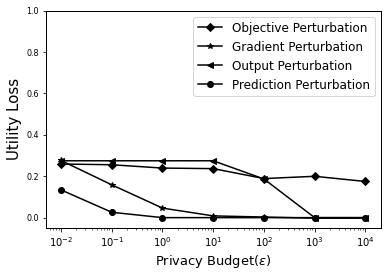

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
plt.semilogx(ep,non_p-acc_obj,color="black",marker='D',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,np_sgd-acc_sgd,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
plt.semilogx(ep,np_out-acc_out,color="black",marker='<',label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,accnp-acc_pate,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=12)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("Utility Loss",fontsize=15)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([-.05,1])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('logistic_perturb_acc_Cifar.pdf')
files.download('logistic_perturb_acc_Cifar.pdf')

Attack

In [ ]:
#Assign necessary variables for attacking the model
import argparse
import csv
import numpy as np
from sklearn.utils import resample, shuffle

import keras
import numpy as np
from sklearn.utils import resample

LEARNING_RATE = 0.001
EPOCH = 100
#EPOCH = 30
DATA_SIZE = 30000
TRAINING_SIZE = 15000
TEST_SIZE = 15000
NUM_TARGET = 1
#NUM_SHADOW = 100
NUM_SHADOW = 10
IN = 1
OUT = 0
VERBOSE = 0

In [ ]:
#call required libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

In [ ]:
#Define model configuaration
# Model configuration
batch_size = 250
#img_width, img_height, img_num_channels = 32, 32, 3
#loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 250
optimizer = Adam()
validation_split = 0.2
verbosity = 0

In [ ]:
#building a logistic regression model with keras
def build_lg_model(num_class=10):
    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    # build the model
    model = Sequential()
    model.add(Dense(units=10,kernel_initializer='glorot_uniform', activation='sigmoid',kernel_regularizer=l2(.0001)))
    return model

In [ ]:
#data sampling
def sample_data(train_data,test_data,num_sets):
    n=15000
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    new_x_train, new_y_train = [], []
    new_x_test, new_y_test = [], []
    for i in range(num_sets):
        x_temp, y_temp = resample(x_train, y_train, n_samples=n, random_state=0)
        new_x_train.append(x_temp)
        new_y_train.append(y_temp)
        x_temp, y_temp = resample(x_test, y_test, n_samples=n, random_state=0)
        new_x_test.append(x_temp)
        new_y_test.append(y_temp)
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [ ]:
def get_trained_keras_models(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(keras.models.clone_model(keras_model))
        models[i].compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=250, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
from sklearn.linear_model import LogisticRegression
def get_trained_keras_models_lg(train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        #models.append(keras.models.clone_model(keras_model))
        #models[i].compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
        #models[i].fit(x_train[i], y_train[i], batch_size=32, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        models.append(LogisticRegression(random_state=0))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i], y_test[i])
        print('\n', 'Model ', i, ' test accuracy:', score)
    return models

In [ ]:
def get_trained_keras_models_target(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(keras.models.clone_model(keras_model))
        models[i].compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=32, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
#collect the attack dataset from shadow models
def get_attack_dataset(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = len(y_train[0][0])
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #print(y_idx)
            y_data[y_idx].append(IN)
            print("starts1",j)
        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            p=models[i].predict(x_temp[j:j+1])[0]
            x_data[y_idx].append(p)
            y_data[y_idx].append(OUT)
            print("starts2",j)
    return x_data, y_data

In [ ]:
#collect the attack dataset from shadow models: Logistic Regression
def get_attack_dataset_lg(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = 10
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = y_temp[j]
            x_data[y_idx].append(models[i].predict_proba(x_temp[j:j+1]))
            print("complete")
            y_data[y_idx].append(IN)
            print("starts1",j)
        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = y_temp[j]
            p=models[i].predict_proba(x_temp[j:j+1])
            x_data[y_idx].append(p)
            y_data[y_idx].append(OUT)
            print("starts2",j)
    return x_data, y_data

In [ ]:
#generate the report
def get_leakage(models, test_data):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import average_precision_score
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    (x_test, y_true) = test_data
    acc_scores = []
    pre_scores = []
    rec_scores = []
    fp=np.zeros(len(models))
    tp=np.zeros(len(models))
    tn=np.zeros(len(models))
    fn=np.zeros(len(models))
    avg=len(models)
    for i in range(len(models)):
        #x_train[i]=np.array(x_train[i])
        #x_train[i]=x_train[i].reshape(x_train[i].shape[0],10)
        x_test[i]=np.array(x_test[i])
        x_test[i]=x_test[i].reshape(x_test[i].shape[0],10)
        x_test[i]=np.nan_to_num(x_test[i])
        y_pred = models[i].predict(x_test[i])
        #print(len(models))
        # _LOG_PRINT(y_pred)
        acc_scores.append(accuracy_score(y_true[i], y_pred))
        pre_scores.append(average_precision_score(y_true[i], y_pred))
        rec_scores.append(recall_score(y_true[i], y_pred))
        tn[i], fp[i], fn[i], tp[i] = confusion_matrix(y_true[i], y_pred).ravel()
    return np.sum(tn),np.sum(tp),np.sum(fn),np.sum(fp)

In [ ]:
#attack classifier:SVM
def get_trained_svm_models(train_data, test_data, num_models):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        #print(i)
        print('SVM model ', i, 'score : ',score)
    return models,score

In [ ]:
y_train=to_categorical(y_train)
y_train=label(y_train)
y_test=to_categorical(y_test)
y_test=label(y_test)

In [ ]:
shadow_train = (X_train[n:n*2],y_train[n:n*2])
shadow_test = (X_test[n:n*2],y_test[n:n*2])
shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

In [ ]:
#when we use logistic regression model from sklearn
shadow_models = get_trained_keras_models_lg(shadow_train_data, shadow_test_data, NUM_SHADOW)
attack_train = get_attack_dataset_lg(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)

In [ ]:
def lk(tn,tp,fn,fp):
  tpr=(tp/(tp+fn))
  fpr=(fp/(fp+tn))
  return tpr-fpr

In [ ]:
##attack classifier:RF
def get_trained_RF_models(train_data, test_data, num_models):
    from sklearn.ensemble import RandomForestClassifier
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    score=np.zeros(num_models)
    #RF=RandomForestClassifier(random_state=0)
    for i in range(num_models):
        print('Training RF model : ', i)
        x_train[i]=np.array(x_train[i])
        x_train[i]=x_train[i].reshape(x_train[i].shape[0],10)
        x_test[i]=np.array(x_test[i])
        x_test[i]=x_test[i].reshape(x_test[i].shape[0],10)
        models.append(RandomForestClassifier(random_state=0))
        models[i].fit(x_train[i], y_train[i])
        score[i] = models[i].score(x_test[i],y_test[i])
        print('Random Forest model ', i, 'score : ',score)
    return models, score

In [ ]:
n=15000
xtrain=X_train[0:n]
ytrain=y_train[0:n]
#ytrain_agg=ytrain_agg.to_numpy()
#ytrain_pred=model_np.predict_proba(xtrain_agg)
xtest=X_test[0:n]
ytest=y_test[0:n]
#ytest_agg=ytest_agg.to_numpy()
#ytest_pred=model_np.predict_proba(xtest_agg)
target_train_agg = (xtrain,ytrain)
target_test_agg = (xtest,ytest)
target_train_data, target_test_data = sample_data(target_train_agg, target_test_agg, 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
target_model=[]
model= LogisticRegression(penalty='l2',max_iter=100,C=10000,multi_class='ovr').fit(xtrain, ytrain)
target_model.append(model)

In [ ]:
#logistic regression
#non_private_model
attack_test_agg=get_attack_dataset_lg(target_model, target_train_data, target_test_data, 1, TEST_SIZE)

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    k=0
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
        k=k+1
        print('this is executable',k)
    return models,score

In [ ]:
#non_private
attack_model,scores = get_trained_svm_models(attack_train,attack_test_agg, 10)
#scores=get_score_svm_models(attack_model,attack_train)
tn,tp,fn,fp=get_leakage(attack_model, attack_test_agg)
l1=lk(tn,tp,fn,fp)

Privacy Leakage Input Perturbation

In [ ]:
def Input_pert_train(epi,xtrain,ytrain,xtest,ytest):
  delta=.00001
  z=3*np.log(15000)
  z1=z**2
  sigma=z1*(8*np.log(2/(delta/2))+4*epi)/(epi**2)
  #sigma=calc_sigma(ep[i],delta,18,1/C)
  nsi=np.random.normal(loc=0.0, scale=sigma/n)
  print(nsi)
  X_in=xtrain-nsi
  target_train_aggin = (X_in,ytrain)
  target_test_aggin = (xtest,ytest)
  target_train_datain, target_test_datain = sample_data(target_train_aggin, target_test_aggin, 1)
  return X_in,target_train_datain,target_test_datain

In [ ]:
p=len(ep)
lin=np.zeros(p)
tn0=np.zeros(p)
tp0=np.zeros(p)
fn0=np.zeros(p)
fp0=np.zeros(p)

for i in range(len(ep)):
     target_model=[]
     X_in,target_train_datain,target_test_datain=Input_pert_train(ep[i],xtrain,ytrain,xtest,ytest)
     in_model=LogisticRegression(penalty='l2',max_iter=100,C=10000).fit(X_in, ytrain)
     target_model.append(in_model)
     attack_test_agg=get_attack_dataset_lg(target_model, target_train_datain, target_test_datain, 1, TEST_SIZE)
     tn0[i],tp0[i],fn0[i],fp0[i]=get_leakage(attack_model, attack_test_agg)
     lin[i]=lk(tn0[i],tp0[i],fn0[i],fp0[i])

In [ ]:
print(lin)  #Input Perturbation privacy leakage
print(tp0)  #Input Perturbation True Positive Value

Privacy Leakage for Objective Perturbation

In [ ]:
from diffprivlib.models import LogisticRegression
p=len(ep)
lobj=np.zeros(p)
tn1=np.zeros(p)
tp1=np.zeros(p)
fn1=np.zeros(p)
fp1=np.zeros(p)
for i in range(len(ep)):
     target_model=[]
     obj_model=LogisticRegression(data_norm=1, epsilon=ep[i],penalty='l2',max_iter=100,C=10000).fit(xtrain, ytrain)
     target_model.append(obj_model)
     attack_test_agg=get_attack_dataset_lg(target_model, target_train_data, target_test_data, 1, TEST_SIZE)
     tn1[i],tp1[i],fn1[i],fp1[i]=get_leakage(attack_model, attack_test_agg)
     lobj[i]=max(0,lk(tn1[i],tp1[i],fn1[i],fp1[i])


In [ ]:
print(lobj)
print(fp1)


Privacy Leakage: Gradient Perturbation

In [ ]:
p=len(ep)
lgd=np.zeros(p)
tn2=np.zeros(p)
tp2=np.zeros(p)
fn2=np.zeros(p)
fp2=np.zeros(p)
for i in range(len(ep)):
     target_model=[]
     modelSGD=globals()['model_sgd%s' % i]
     target_model.append(modelSGD)
     attack_test_agg=get_attack_dataset_lg(target_model, target_train_data, target_test_data, 1, TEST_SIZE)
     tn2[i],tp2[i],fn2[i],fp2[i]=get_leakage(attack_model, attack_test_agg)
     lgd[i]=max(0,lk(tn2[i],tp2[i],fn2[i],fp2[i]))

In [ ]:
print(lgd)
print(tp2)



[0.         0.         0.00953333 0.01613333 0.0262     0.03793333
 0.0432    ]
[4598. 4336. 5864. 7142. 7464. 7680. 7800.]

Output Perturbation

In [ ]:
from tensorflow import keras
def output_pert(ep):
  #add noise to the weights
  #noise=(2/(n1*ep[i]*.0001))
  n1=15000 
  delta=.00001
  s=2/(n1*.0001)  #lambda=.0001
  model1=keras.models.load_model("my_model")
  w=model1.get_weights()
  #print(w[0])
  W=w
  sigma = np.sqrt(2 * np.log(1.25 / delta)) * (s / ep)
  #ns=np.random.laplace(loc=0.0, scale=noise)
  ns=np.random.normal(loc=0.0, scale=sigma)
  print(ns)
  #print(ns)
  for j in range(2):
       W[j]=W[j]+ns
  #print(W[0])
  model2=keras.models.load_model("my_model")
  model2.set_weights(W)
  #acc_out[i]=calc_labelAcc(model2,xtest,testY[0:n])
  return model2


In [ ]:
p=len(ep)
lout=np.zeros(p)
tn3=np.zeros(p)
tp3=np.zeros(p)
fn3=np.zeros(p)
fp3=np.zeros(p)
for i in range(p):
     target_model=[]
     model_out=output_pert(ep[i])
     target_model.append(model_out)
     attack_test_agg=get_attack_dataset_lg(target_model, target_train_data, target_test_data, 1, TEST_SIZE)
     tn3[i],tp3[i],fn3[i],fp3[i]=get_leakage(attack_model, attack_test_agg)
     lout[i]=max(0,lk(tn3[i],tp3[i],fn3[i],fp3[i]))
     print("complete")

In [ ]:
print(lout)
print(tp3)


PATE_attack

In [ ]:
def PATE(ep,xtest1,ytest1):
            sum_t=np.zeros([len(ytest1),10])
            for k1 in range(100):
               sum=PATE_sum(xtest1,ytest1)
               sum_s=np.zeros(sum.shape)
               sum_n=sum
               sum_s=sum_n+np.random.laplace(loc=0.0, scale=1/ep)
               sum_t=sum_s+sum_t

            return sum_t/100
          


In [ ]:
def PATE_sum(xtest1,ytest1):
  sum=np.zeros([len(ytest1),10])
  for iter in range(M):
    New_model=globals()['model_pate%s' % iter]
    y=np.zeros([len(ytest1),10])
    y=New_model.predict_proba(xtest1)
  #print(y.shape)
    y=vote(y)
    sum=y+sum
  return sum

In [ ]:
#Get the prediction vectors from the DP model
def get_attack_dataset_combined_lg(x_train, x_test, train_pred, y_train, y_test, test_pred):
    # generate dataset for the attack model
    #(x_train, y_train), (x_test, y_test) = train_data, test_data
    data_size=len(y_train)
    num_class = 10
    x_data, y_data = [[] for _ in range(num_class)], [[] for _ in range(num_class)]
    #for i in range(num_models):
        # IN data
    #x_temp, y_temp = resample(x_train, y_train, n_samples=data_size, random_state=0)
    for j in range(data_size):
            y_idx = y_train[j]
            x_data[y_idx].append(train_pred[j])
            #print(train_pred[j])
            #x_data[y_idx].append(models.predict(x_temp[j:j+1])[0])
            y_data[y_idx].append(IN)
        # OUT data
    #x_temp, y_temp = resample(x_test, y_test, n_samples=data_size, random_state=0)
    for j in range(data_size):
            y_idx = y_test[j]
            #x_data[y_idx].append(models.predict(x_temp[j:j+1])[0])
            x_data[y_idx].append(test_pred[j])
            y_data[y_idx].append(OUT)
    return x_data, y_data

In [ ]:
p=len(ep)
lpate=np.zeros(p)
tn4=np.zeros(p)
tp4=np.zeros(p)
fn4=np.zeros(p)
fp4=np.zeros(p)
for i in range(len(ep)):
     ytrain_pred=PATE(ep[i],xtrain,ytrain)
     ytest_pred=PATE(ep[i],xtest,ytest)
     attack_test_agg=get_attack_dataset_combined_lg(xtrain,xtest,ytrain_pred,ytrain,ytest,ytest_pred)
     tn4[i],tp4[i],fn4[i],fp4[i]=get_leakage(attack_model, attack_test_agg)
     lpate[i]=max(0,lk(tn4[i],tp4[i],fn4[i],fp4[i]))

In [ ]:
print(lpate)
print(tp4)


Graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

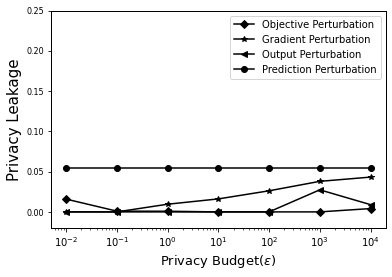

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
plt.semilogx(ep,lobj,color="black",marker='D',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,lgd,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
plt.semilogx(ep,lout,color="black",marker='<',label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,lpate,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.semilogx(ep,non_p-acc_in,color="orange",marker='.',linestyle="--",label='Input',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=10)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("Privacy Leakage",fontsize=15)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([-.02,.25])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('logistic_perturb_leakage_cifar.pdf')
files.download('logistic_perturb_leakage_cifar.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

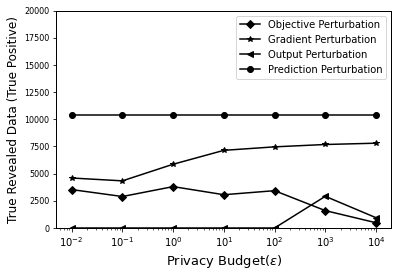

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
plt.semilogx(ep,tp1,color="black",marker='D',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,tp2,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
plt.semilogx(ep,tp3,color="black",marker='<',label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,tp4,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.semilogx(ep,non_p-acc_in,color="orange",marker='.',linestyle="--",label='Input',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=10)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("True Revealed Data (True Positive)",fontsize=12)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([-1,20000])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('logistic_perturb_tp_cifar.pdf')
files.download('logistic_perturb_tp_cifar.pdf')